In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import sys

import pandas as pd
from tqdm import tqdm
import torch

from fastai.callback.schedule import lr_find, fit_one_cycle
from fastai.data.load import DataLoader
from fastai.data.core import DataLoaders
from fastai.layers import BCEWithLogitsLossFlat
from fastai.learner import Learner
from fastai import metrics

from sklearn.model_selection import train_test_split
from sklearn import metrics as sk_metrics
from transformers import BertTokenizer, BertModel

sys.path.append('../src/')

import preprocessing
from superhero_data import SuperHeroDataset
from model import SuperHeroNet

# Load data

In [3]:
tokenizer, model = preprocessing.get_bert(name='bert-base-uncased')
with open('../data/data.pkl', 'rb') as f:
    result = pickle.load(f)
    cols = result['columns']
    df = result['data'][cols]
    idx2power = result['idx2power']
    power2idx = result['power2idx']
    universe2idx = result['universe2idx']

print(df.shape)
df.head(2)

(897, 17)


,name,powers,powers_idx,identity_num,gender_num,universe_num,alias,real_name,height,weight,aliases,affiliation,occupation,citizenship,eyes,origin,hair
27,89P13 (Earth-199999),"[enhanced agility, enhanced strength, enhaced/superhuman intelligence or genius, enhanced condition]","[43, 41, 50, 44]",0,0,25,Rocket,89P13,NaN,NaN,,"Guardians of the Galaxy; formerly Avengers, ally of Wakandans and White Wolf",Adventurer; former mercenary,,Brown,Halfworlder Mutate and Cyborg,"Black Brown, and White"
38,A'Lars (Earth-616),"[invulnerability, flight, manipulation powers, cosmic powers, cosmic energy powers]","[72, 55, 83, 24, 23]",0,0,48,Mentor,A'Lars,1.85,210.0,,"Formerly Eternals of Titan, Eternals of Titanos",Ruler of the Eternals of Titan,"Titanian Eternals, formerly Titanos",Blue,Eternal,White (formerly black)


In [4]:
string_cols = {'affiliation', 'occupation', 'citizenship', 'eyes', 'origin', 'hair'}
excluded_cols = {'aliases', 'alias'}
cols = set(df.columns) - string_cols - excluded_cols

values = {col : '' for col in string_cols}

df = df.fillna(value=values)

#data = SuperHeroDataset(df, 'bert-base-uncased', '[CLS]', '[SEP]', 0, folder='../data/pickles/')

# Split data

In [5]:
df_train, df_val = train_test_split(df, test_size=0.2)
df1 = df_train[['powers_idx']].explode('powers_idx').assign(count=1).groupby('powers_idx', as_index=False).count()

df2 = df_val[['powers_idx']].explode('powers_idx').assign(count=1).groupby('powers_idx', as_index=False).count()

for i, row in pd.merge(df1, df2, on='powers_idx', how='outer').fillna(0).iterrows():
    print(idx2power[row['powers_idx']], int(row['count_x']), int(row['count_y']))

above super (god, unlimited) strength 10 1
absorption powers 41 10
acid powers 3 4
adaptation powers 11 5
allspeak 15 3
amphibious powers 11 3
astral powers 25 8
astral projection 21 7
atmokinesis 4 2
awareness 5 1
beams powers 7 4
blades 5 3
blasts powers 55 18
bolt powers 7 2
breath powers 7 3
camouflage 22 3
chi powers 13 2
claws 44 8
cloak/stealth powers 9 4
concussive powers 19 5
conjuring powers 5 2
construct powers 11 6
cosmic awareness 9 2
cosmic energy powers 12 2
cosmic powers 37 6
cybernetic enhancements 6 3
darkforce powers 4 2
demon powers 6 0
dimensional powers 12 3
discharge powers 6 1
disintegration 4 1
duplication 8 2
earth/geo powers 10 2
electrokinesis 7 3
electromagnetic powers 8 1
elemental powers 5 3
eletric powers 11 2
emission powers 6 1
empathy/emphatical powers 12 3
empowerment powers 5 1
energy powers 79 27
enhaced/superhuman intelligence or genius 13 6
enhacements 10 3
enhanced agility 31 15
enhanced condition 5 0
enhanced durability 32 17
enhanced endurance

In [6]:
n_classes = max([max(z) for z in df['powers_idx'].values]) + 1
print(n_classes)

train_path = '../data/train/v1/'
val_path = '../data/val/v1/'

159


In [7]:
train = SuperHeroDataset(df_train, 'bert-base-uncased', '[CLS]', '[SEP]', 0, n_classes, folder=train_path)
val = SuperHeroDataset(df_val, 'bert-base-uncased', '[CLS]', '[SEP]', 0, n_classes, folder=val_path)

for path, data in zip([train_path, val_path], [train, val]):
    with open(path + 'data.pkl', 'wb') as f:
        pickle.dump(data, f)

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [02:26<00:00,  1.23it/s]


In [7]:
with open(train_path + 'data.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open(val_path + 'data.pkl', 'rb') as f:
    val = pickle.load(f)

# DataLoaders

In [8]:
train_dl = DataLoader(train, bs=64, shuffle=True)
val_dl = DataLoader(val, bs=256)
data = DataLoaders(train_dl, val_dl)

# Model

In [9]:
emb_columns = [(col, len(df[col].unique())) for col in train.EMBEDDING_COLS]

net = SuperHeroNet(emb_columns=emb_columns,
                   n_input=train[0][0].shape[0],
                   n_classes=n_classes,
                   p=[0.8, 0.5])

In [10]:
import numpy as np
# Weights
weights = df[['powers_idx']].explode('powers_idx').assign(count=1).groupby('powers_idx', as_index=False).count()

total = df.shape[0]
print(total)
pos_weights = total / weights.sort_values(by='powers_idx')['count'].values

897


# Learner

In [12]:
from losses import BPRLossFlat
model_path = '../'

# 0.0-1.0
'''
learn = Learner(data, net, 
                loss_func=BCEWithLogitsLossFlat(pos_weights=pos_weights), 
                path=model_path, 
                metrics=[metrics.accuracy_multi, metrics.F1ScoreMulti()])
'''
# >=2.0
learn = Learner(data, net, 
                loss_func=BPRLossFlat(neg_sample=n_classes), 
                path=model_path, 
                metrics=[metrics.accuracy_multi, metrics.F1ScoreMulti()])

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=8.31763736641733e-06)

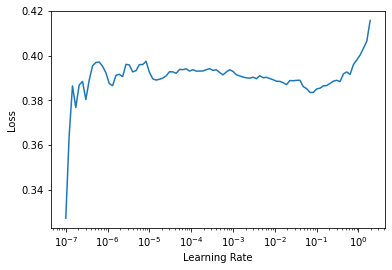

In [20]:
learn.lr_find()

In [21]:
n = 1
for i in range(n):
    learn.fit_one_cycle(3, lr_max=1e-3)

(#6) [0,0.38124457001686096,0.45678582787513733,0.7735499739646912,0.051405749436462,'00:02']
(#6) [1,0.38343024253845215,0.45549291372299194,0.7770090699195862,0.05155281730328761,'00:02']
(#6) [2,0.3841182589530945,0.45570603013038635,0.7767994403839111,0.051353870418192914,'00:02']


In [22]:
learn.save('v1.3')

Path('../models/v1.3.pth')

In [75]:
learn.load('v1.3')

In [23]:
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(learn.model, f)

# Evaluate
* acc = Accuracy with y_pred = y_score > 0.5
* acc2 = Accuracy that chooses the k scores (k is # labels on the real set)

In [24]:
'''
with torch.no_grad():
    x, emb_data, y = val_dl.one_batch()
    z = (learn.model.forward(x, emb_data), y)
'''

z = learn.get_preds()

In [26]:
def my_roc_auc(y_true, y_score):
    if y_true.sum() > 0:
        return sk_metrics.roc_auc_score(y_true, y_score)
    else:
        return None

In [27]:
thresh = 0.5
y_score = z[0]
y_true = z[1]

y_pred = (y_score > thresh).long()

eq = y_pred == y_true

y_n_labels = y_true.sum(axis=1)

y_pred2 = [torch.nn.functional.one_hot(torch.topk(y_score[i], k=k, 
                                                  largest=True, sorted=True)[1], 
                                       num_classes=n_classes).sum(axis=0)
           for i, k in enumerate(y_n_labels)]

y_pred2 = torch.stack(y_pred2)

eq2 = y_pred2 == y_true

acc_tot = [(z.sum() * 100.0 / (y_true.shape[0] * n_classes)).item() for z in [eq, eq2]]

acc = [(z.sum(axis=0) * 100.0 / y_true.shape[0]) for z in [eq, eq2]]

tp = torch.logical_and(y_pred2, y_true).sum(axis=0)
prec = tp * 1.0 / y_pred2.sum(axis=0)
recall = tp * 1.0 / y_true.sum(axis=0)

print(acc_tot)

df_agg = df[['powers_idx']].explode('powers_idx').assign(count=1).groupby('powers_idx', as_index=False).count()


df_agg['acc'] = df_agg['powers_idx'].apply(lambda x: acc[0][x].item())
df_agg['acc2'] = df_agg['powers_idx'].apply(lambda x: acc[1][x].item())
df_agg['roc'] = df_agg['powers_idx'].apply(lambda x: my_roc_auc(y_true[:, x], y_score[:, x]))
df_agg['prec'] = df_agg['powers_idx'].apply(lambda x: prec[x].item())
df_agg['recall'] = df_agg['powers_idx'].apply(lambda x: recall[x].item())

df_agg['power'] = df_agg['powers_idx'].apply(lambda x: idx2power[x])


[77.67994689941406, 95.1502456665039]


In [28]:
pd.set_option('display.max_rows', None)

df_agg.sort_values(by='count', ascending=False)

,powers_idx,count,acc,acc2,roc,prec,recall,power
138,138,406,39.444443,42.222221,0.491924,0.405714,1.000000,superhuman strength
133,133,312,31.666666,51.666668,0.471259,0.391304,0.947368,superhuman durability
137,137,262,26.111111,50.000000,0.624220,0.343066,1.000000,superhuman stamina
136,136,227,21.666666,67.777779,0.511729,0.400000,0.974359,superhuman speed
111,111,187,17.777779,51.666668,0.646968,0.196078,0.800000,regenerative healing factor
131,131,182,19.444445,77.222221,0.565123,0.450000,0.771429,superhuman agility
135,135,174,20.000000,78.333336,0.531829,0.470588,0.666667,superhuman reflexes
83,83,161,14.444445,63.333332,0.555944,0.261905,0.846154,manipulation powers
55,55,156,17.222221,76.111115,0.473046,0.375000,0.580645,flight
117,117,122,16.111111,85.000000,0.445052,0.380952,0.363636,senses powers


In [97]:
x, emb_data, y = val[1]
z = learn.model.forward(x.unsqueeze(0), emb_data.unsqueeze(0))

In [59]:
y_pred_scores, y_pred = torch.topk(z.squeeze(), k=8, largest=True, sorted=True)

powers = [idx2power[idx] for idx in y_pred.tolist()]
powers

['superhuman strength',
 'superhuman stamina',
 'superhuman durability',
 'superhuman reflexes',
 'superhuman agility',
 'superhuman speed',
 'regenerative healing factor',
 'flight']

In [88]:
x, emb_data, y = val[0]
print(y)
print(torch.nonzero(y))

print(sorted(val.df['powers_idx'].iloc[0]))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])
tensor([[ 59],
        [121],
        [131],
        [133],
        [135],
        [136],
        [137],
        [138],
        [155],
        [157]])
[59, 121, 131, 133, 135, 136, 137, 138, 155, 157]


In [120]:
val.df.iloc[2]

name                                                                                                                                                                                            Thanos (Earth-12041)
powers          [invulnerability, energy powers, shields powers, superhuman strength, resurrection, techno powers, manipulation powers, blasts powers, concussive powers, enhaced/superhuman intelligence or genius]
powers_idx                                                                                                                                                              [72, 40, 119, 138, 113, 143, 83, 12, 19, 41]
identity_num                                                                                                                                                                                                       2
gender_num                                                                                                                                          

# Streamlit
Ejecutar streamlit run app.py